Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

## Lab 10

We will try to formulate this problem as a Markov Decision Process and then use Reinforcement Learning to train an agent into winning Tic-Tac-Toe. I'm going to use some of the code that the professor wrote in class. Since the environment of the agent is not very complez, we are going to opt for model free RL. So we are not looking at anything else other than the reward the agent gets at the end. I was considering using value iteration, but since I don't really know the transition probabilities from one state to another I will use Q-learning instead.

In [2]:
from itertools import combinations
from collections import namedtuple, defaultdict, Counter
from random import choice, randrange, random
from copy import deepcopy
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import numpy as np

c:\Users\Arist\OneDrive\Dokumenter\Høst2023\Computational intelligence\exercises\computational-intelligence\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
State = namedtuple('State', ['x', 'o'])

In [4]:
class Agent:
    def __init__(self, Q_table: defaultdict[defaultdict[float]], lr: float, epsilon: float, dr: float, type: str):
        self.Q_table = Q_table
        self.lr = lr
        self.epsilon = epsilon
        self.dr = dr
        self.type = type

    def update_Q_table(self, state: State(set, set), action: int, next_state: State(set, set), available: set, reward: int):

        hashable_state = (frozenset(state.x), frozenset(state.o))
        hashable_next_state = (frozenset(next_state.x), frozenset(next_state.o))

        next_sa_values = [self.Q_table[hashable_next_state][next_action] for next_action in available]
        max_next = max(next_sa_values) if next_sa_values else 0.0
        # here I'm using the bellman equation:
        # Q(s, a) = Q(s, a) + lr * (r + dr*max_a(Q(s',a')) - Q(s,a))
        self.Q_table[hashable_state][action] += self.lr * (reward + self.dr*max_next - self.Q_table[hashable_state][action])

    def pick_action(self, available: set, state: State(set, set)):

        state = (frozenset(state.x), frozenset(state.o))

        best_action = choice(list(available))

        if random() < self.epsilon:
            return best_action
        
        best_action_value = self.Q_table[state][best_action]

        available.remove(best_action)

        if available:
            for action in available:
                action_value = self.Q_table[state][action]
                if action_value > best_action_value:
                    best_action = action
                    best_action_value = action_value
        
        return best_action

In [5]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

In [6]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()

In [7]:
def win(elements):
    """Checks is elements is winning"""
    return any(sum(c) == 15 for c in combinations(elements, 3))

def evaluate_state(pos: State):
    """Evaluate state: +1 first player wins"""
    if win(pos.x):
        return 1
    elif win(pos.o):
        return -1
    else:
        return 0

In [8]:
def play_game(agent1: Agent, agent2: Agent):
    x_trajectory = list()
    o_trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    last_state = None
    num_ply = 0
    while available:

        if num_ply != 0:
            agent1.update_Q_table(current_state_x, action_x, deepcopy(state), deepcopy(available), 0)
        
        action_x = agent1.pick_action(deepcopy(available), state)
        current_state_x = deepcopy(state)
        x_trajectory.append((current_state_x, action_x))
        available.remove(action_x)
        state.x.add(action_x)
        
        if not available:
            last_state = deepcopy(state)
            agent1.update_Q_table(current_state_x, action_x, last_state, [], 0)
            agent2.update_Q_table(current_state_o, action_o, last_state, [], 0.5)
            break
        if win(state.x):
            last_state = deepcopy(state)
            agent1.update_Q_table(current_state_x, action_x, last_state, [], 1)
            agent2.update_Q_table(current_state_o, action_o, last_state, [], -1)
            break

        if num_ply != 0:
            agent2.update_Q_table(current_state_o, action_o, deepcopy(state), deepcopy(available), 0)

        action_o = agent2.pick_action(deepcopy(available), state)
        current_state_o = deepcopy(state)
        o_trajectory.append((current_state_o, action_o))
        available.remove(action_o)
        state.o.add(action_o)

        if win(state.o):
            last_state = deepcopy(state)
            agent1.update_Q_table(current_state_x, action_x, last_state, [], -1)
            agent2.update_Q_table(current_state_o, action_o, last_state, [], 1)
            break

        num_ply += 1
    
    return last_state # list of (state, action) pairs

In [9]:
def train(agent1: Agent, agent2: Agent, num_games: int):

    performance_check = dict()

    for steps in tqdm(range(num_games)):
        last_state = play_game(agent1, agent2)
        assert last_state != None

        if steps % (num_games / 100) == 0:
            
            win_record = []
            best_agent = Agent(agent1.Q_table, lr=0, epsilon=0, dr=0, type='x')
            random_agent = Agent(agent2.Q_table, lr=0, epsilon=1, dr=0, type='o')

            for i in range(1000):
                last_state = play_game(best_agent, random_agent)
                winner = evaluate_state(last_state)
                win_record.append(winner)

            performance_check[steps] = Counter(win_record)
    
    return performance_check

## Procedure

First I'm training the agent against a random agent, and also with 100% exploration (epsilon = 1.0), this is to prevent overfitting and letting the agent first explore the environment. I found that the learning rate of 0.1 was best to get convergence. Discount rate didn't really matter that much, but should be relatively high.

In [10]:
Q_table = defaultdict(lambda: defaultdict(lambda: random()))
hit_state = defaultdict(int)

EPSILON = 1 # Chance of choosing random move instead of best move
LEARNING_RATE = 0.1
DISCOUNT_RATE = 1.0


agent1 = Agent(Q_table, lr=LEARNING_RATE, epsilon=EPSILON, dr=DISCOUNT_RATE, type='x')
agent2 = Agent(Q_table, lr=LEARNING_RATE, epsilon=1, dr=DISCOUNT_RATE, type='o')

training_stats = train(agent1, agent2, 100_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [03:14<00:00, 513.85it/s]


In [11]:
print(training_stats)

{0: Counter({1: 565, -1: 308, 0: 127}), 1000: Counter({1: 580, -1: 288, 0: 132}), 2000: Counter({1: 726, -1: 152, 0: 122}), 3000: Counter({1: 580, -1: 285, 0: 135}), 4000: Counter({1: 613, -1: 230, 0: 157}), 5000: Counter({1: 648, -1: 249, 0: 103}), 6000: Counter({1: 626, -1: 243, 0: 131}), 7000: Counter({1: 623, -1: 235, 0: 142}), 8000: Counter({1: 647, -1: 200, 0: 153}), 9000: Counter({1: 687, -1: 188, 0: 125}), 10000: Counter({1: 721, -1: 140, 0: 139}), 11000: Counter({1: 679, -1: 190, 0: 131}), 12000: Counter({1: 698, -1: 183, 0: 119}), 13000: Counter({1: 700, 0: 163, -1: 137}), 14000: Counter({1: 771, -1: 146, 0: 83}), 15000: Counter({1: 748, 0: 131, -1: 121}), 16000: Counter({1: 713, -1: 157, 0: 130}), 17000: Counter({1: 783, -1: 154, 0: 63}), 18000: Counter({1: 843, -1: 116, 0: 41}), 19000: Counter({1: 891, -1: 57, 0: 52}), 20000: Counter({1: 778, -1: 151, 0: 71}), 21000: Counter({1: 844, -1: 85, 0: 71}), 22000: Counter({1: 870, -1: 81, 0: 49}), 23000: Counter({1: 903, 0: 51, -1

Text(0.5, 1.0, 'Number of games lost (out of 1000) vs games played')

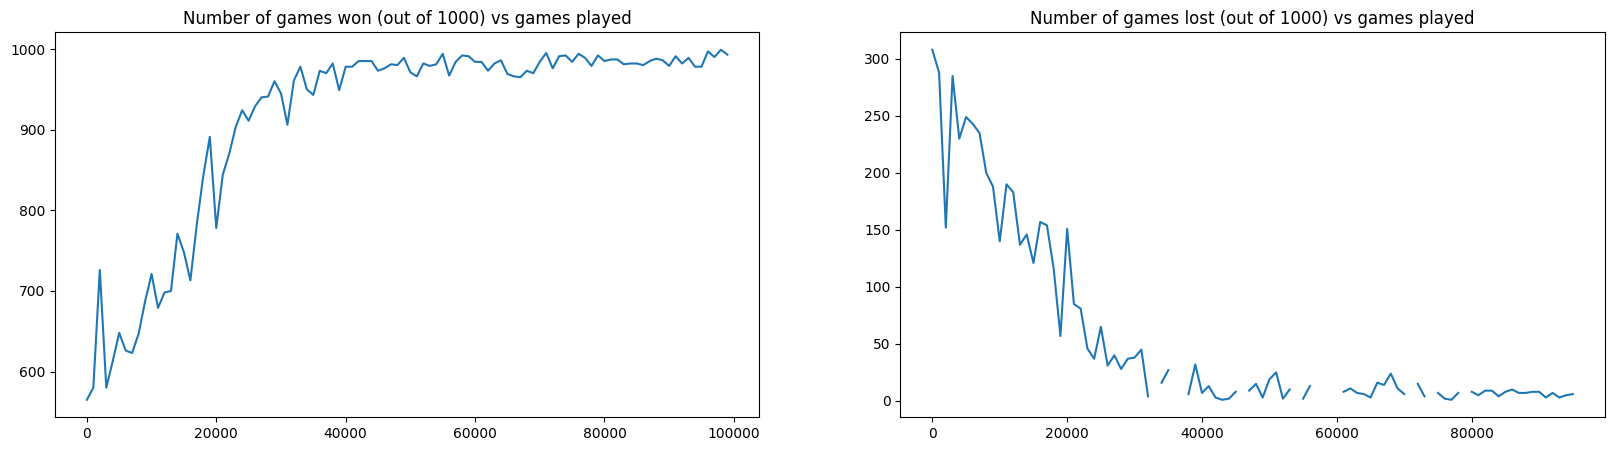

In [12]:
fig, (ax_won, ax_lost) = plt.subplots(1, 2, figsize=(20, 5))

y_won = []

y_lost = []

x = []


for i, win_record in training_stats.items():
    x.append(i)
    y_won.append(win_record.get(1))
    y_lost.append(win_record.get(-1))

ax_won.plot(np.array(x), np.array(y_won))
ax_won.set_title("Number of games won (out of 1000) vs games played")


ax_lost.plot(np.array(x), np.array(y_lost))
ax_lost.set_title("Number of games lost (out of 1000) vs games played")


## Second training block

We can see that the first training block was relatively successful in getting near 100% win rate, but there is still a tiny bit of progress to be made. Specifically getting 0% loss rate. I'm therefore training my agent against an already trained agent from before.

In [13]:
# Here I'm training my agent against an already trained agent, making it more difficult to win

trained_agent1 = Agent(agent1.Q_table, lr=0.1, epsilon=0.1, dr=0.9, type='x')
trained_agent2 = Agent(agent2.Q_table, lr=0.1, epsilon=0.1, dr=0.9, type='o')

new_training_stats = train(trained_agent1, trained_agent2, 100_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [03:19<00:00, 500.83it/s]


Text(0.5, 1.0, 'Number of games lost (out of 1000) vs games played')

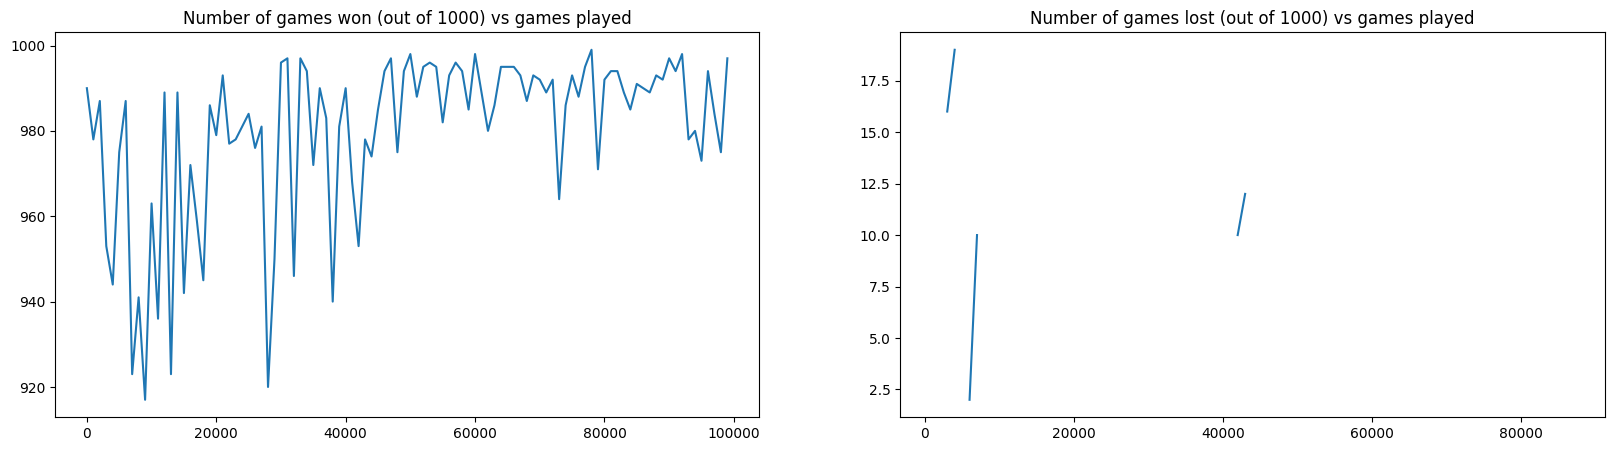

In [14]:
fig, (ax_won, ax_lost) = plt.subplots(1, 2, figsize=(20, 5))

y_won = []

y_lost = []

x = []


for i, win_record in new_training_stats.items():
    x.append(i)
    y_won.append(win_record.get(1))
    y_lost.append(win_record.get(-1))

ax_won.plot(np.array(x), np.array(y_won))
ax_won.set_title("Number of games won (out of 1000) vs games played")

ax_lost.plot(np.array(x), np.array(y_lost))
ax_lost.set_title("Number of games lost (out of 1000) vs games played")

## Results

We see that we could get a tiny bit better and very near a 100% win rate against a random agent. And also we can see that the loss rate is basically 0%, other than some weird spikes here and there, which means we have an optimal agent on our hands.